In [2]:
import xarray as xr
import sys
sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$

Where:

- $[PBDE]_p$ represents the PBDEs concentration retained on the filter.

- $[PBDE]_{d,c}$ is the PBDEs concentrations pasing through the filter.

- $[POC]$ is the Particulate Organic Carbon.

We can use this parameter in Ocean Parcels for changing states between colloids and particuated PBDEs coming out of the pipe.


Option 1: Use the discharge data for PBDEs and use it with the POC data for a modified version of the equation above.

In [3]:
bio = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/12nov23/SalishSea_1h_20231112_20231112_biol_T.nc')

In [4]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [5]:
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])

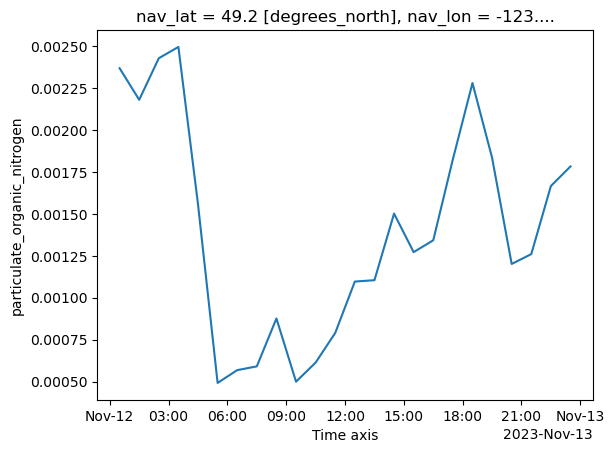

In [6]:
(bio['particulate_organic_nitrogen'][:,0,a,b]*(16/106)).plot()